In [2]:
import rustpycoils as rpc
import magpylib as mag3  
import numpy as np
import math
import matplotlib.pyplot as plt

In [18]:
print("Version of magpylib compared : " + mag3.__version__)

Version of magpylib compared : 3.0.0


# Comparsion to Magpylib

The magpylib library offers a wide range of magnetic field primitives such as geometric objects, dipoles and current primitives. The ideal current loop primitive his is the same moduled using a power series by R.H. Jackson and can therfore be directly compared for accuracy and speed in producing solenoidal fields.


### Define the unit wire loop in each module

The 'unit' wire loop taken to be 1m radius with 1A current centered at the origin and aligned along the z axis

In [44]:
rustcoil = rpc.AxialSystem()
rustcoil.transform_z()

### Parameters
max_distance = 5
radius = 1 
current = 1
length = 5  # As ratio of radius
off_axis = 0.70 # location in radial direction as percentage of radius
tol = 1e-20 # tolerance of rustypy series convergence

rustcoil.add_loop("loop",radius,0.0,current)
unit_loop = mag3.current.Circular(current=1, diameter=2000,position=(0.0,0.0,0.0))  ##magpylib defines in mm
get_magpy_fields = lambda positions: mag3.getB(sources=[unit_loop],observers=[positions])




#### Generate list of positions to compare in correct format

In [45]:
number_positions= 10000
off_axis_pos = np.full(number_positions,off_axis*radius)
z_positions = np.linspace(-length,length,number_positions)
positions = np.asarray(list(zip(off_axis_pos,np.zeros(number_positions),z_positions)))

### Compute magnetic fields 

after finding the magnetic fields for each module find the absolute percentage difference in the magnetic fields.

Also computed the absolute percentage difference of the two common definitions of $\mu_0$, i.e. $4\pi \times 10^{-7}$H/m and $1.25663706212 \times 10^{-6}$ H/m which is $\approx -7.2$ in the log based representation plotted below.

In [46]:
fields_rusty = rustcoil.get_b(positions,tol)
fields_magpy = get_magpy_fields(positions*1000)*1e-3

difference_percentage_z = np.log10(100*abs(((fields_magpy-fields_rusty)/fields_magpy)))  #absolute percentage difference 

from scipy.constants import mu_0
mu_difference = np.log10(100*abs(((4*np.pi*1e-7) - (mu_0))/(1.25663706212*1e-6)))


<ipython-input-46-e4c876df9eec>:4: RuntimeWarning: divide by zero encountered in true_divide
  difference_percentage_z = np.log10(100*abs(((fields_magpy-fields_rusty)/fields_magpy)))  #absolute percentage difference


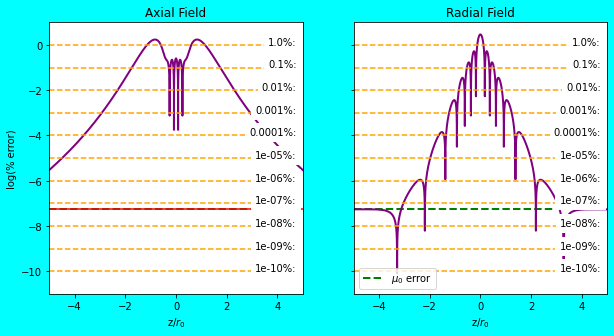

In [47]:
fig, (ax1, ax2)  = plt.subplots(1,2,figsize=(10,5),sharey=True,sharex=True)
def plot_error_lines(ax):
    for i in range(2,13):
        ax.axhline(y=math.log10(100*0.1**i),ls='--',c='orange')
        ax.text(s= str(round(0.1**i*100,14))+ '%:',x = length*0.95,y=math.log10(100*0.1**i),backgroundcolor='white',ha='right')
        
        
ax1.axhline(y=mu_difference,c='green',label =r"$\mu_0$ error",lw=2,ls='--')
ax1.set_ylim(-11,1)
ax1.set_title('Axial Field')
ax1.plot(z_positions/radius,difference_percentage_z[:,2],color='purple',lw=2)
ax1.axhline(y=mu_difference,c='red')
ax1.set_xlabel(r'z/$r_0$')
ax1.set_ylabel('log(% error)')
plot_error_lines(ax1)

ax2.axhline(y=mu_difference,c='green',label =r"$\mu_0$ error",lw=2,ls='--')
plt.xlim(-length,length)
ax2.set_title('Radial Field')
ax2.plot(z_positions/radius,difference_percentage_z[:,0],color='purple',lw=2)
ax2.set_xlabel(r'z/$r_0$')
plt.legend(loc=3)
plot_error_lines(ax2)
fig.patch.set_facecolor('cyan')
plt.savefig('accuracy.png')

## Compare 2D

Now will compare the accuracy in a 2 plot with radial positions out to beyond the radius

In [23]:
number_grid_positions= 1000
z_positions = np.linspace(-5,5,number_grid_positions)
x_positions = np.linspace(0,2*radius,number_grid_positions)
g0,g1 = np.meshgrid(x_positions,z_positions)
grid_positions = np.asarray(list(zip(g0.ravel(),np.zeros(number_grid_positions**2) ,g1.ravel())))

In [24]:
grid_fields_rusty = rustcoil.get_b(grid_positions,tol)
grid_fields_rusty_radial = grid_fields_rusty[:,0]
grid_fields_rusty_axial = grid_fields_rusty[:,2]
grid_fields_magpy = get_magpy_fields(grid_positions*1000)*1e-3
grid_fields_magpy_radial = grid_fields_magpy[:,0]
grid_fields_magpy_axial = grid_fields_magpy[:,2]

radial_grid_abs_percentage_error=np.log10(100*abs(((grid_fields_rusty_radial-grid_fields_magpy_radial)/grid_fields_rusty_radial)))
axial_grid_abs_percentage_error=np.log10(100*abs(((grid_fields_rusty_axial-grid_fields_magpy_axial)/grid_fields_magpy_axial)))

<ipython-input-24-dfb8e8e19bd5>:8: RuntimeWarning: invalid value encountered in true_divide
  radial_grid_abs_percentage_error=np.log10(100*abs(((grid_fields_rusty_radial-grid_fields_magpy_radial)/grid_fields_rusty_radial)))


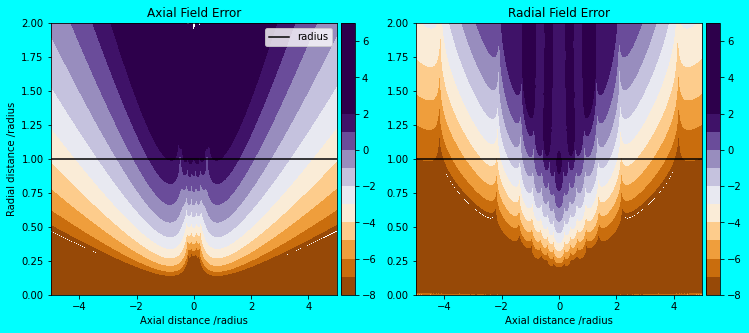

In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.set_title('Axial Field Error')
contourf_ = ax1.contourf(g1,g0,axial_grid_abs_percentage_error.reshape(number_grid_positions,number_grid_positions), levels=range(-8,8),cmap='PuOr',vmax=2,vmin=-8)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(contourf_, cax=cax1)
ax1.axhline(y=1.0,c='black',label='radius')
ax1.legend()
ax1.set_ylabel('Radial distance /radius')
ax1.set_xlabel('Axial distance /radius')

ax2.set_title('Radial Field Error')
ax2.set_xlabel('Axial distance /radius')
contourf_2 = ax2.contourf(g1,g0,radial_grid_abs_percentage_error.reshape(number_grid_positions,number_grid_positions), levels=range(-8,8),cmap='PuOr',vmax=2,vmin=-8)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(contourf_2, cax=cax2)
ax2.axhline(y=1.0,c='black')
fig.patch.set_facecolor('cyan')
plt.savefig('accuracy2.png')

# Speed Comparisons

Rustycoils can give accurate magnetic field values for the ideal wire loop within a large percentage of the radius, It does not however give accurate field values for this primitive shape near to, or beyond, the radius unless the radial distance is much larger than the radius. 

The speed of the algorithim is therefore an important aspect to determine if it is useful for a certain application. The radial positions are kept within 25% of the radius and the axial positions within the radius. 

for these tests In this section perform some basic speed tests:
   - Speed for single position with Ideal loop
   - Speed for many simulataneous positions inside an ideal loop 
   - Speed for single position inside many Ideal loops (approximating a solenoid)

In [26]:
import timeit


In [85]:
def time_single():
    import magpylib as mag3
    ### Parameters
    max_distance = 5
    radius = 1 
    current = 1
    length = 1  # As ratio of radius how far from coil 
    off_axis_max = 0.25 # location in radial direction as percentage of radius
    tol = 1e-20 # tolerance of rustypy series convergence
    rustcoil = rpc.AxialSystem()
    rustcoil.transform_z()
    rustcoil.add_loop("loop",radius,0.0,current)
    unit_loop = mag3.current.Circular(current=1, diameter=2000,position=(0.0,0.0,0.0))  ##magpylib defines in mm
    get_magpy_fields = lambda positions: mag3.getB(sources=[unit_loop],observers=[positions]).sum(axis=0)

    number_grid_positions= 1
    z_positions = np.linspace(-length,length,number_grid_positions)
    x_positions = np.linspace(0,off_axis_max*radius,number_grid_positions)
    g0,g1 = np.meshgrid(x_positions,z_positions)
    
    
    grid_positions = np.asarray([0.1,0.1,0.1]).reshape(-1,3)
    grid_positions_magpy = np.asarray([100.0,100.0,100.0])
    
    time_rusty = timeit.timeit("rustcoil.get_b(grid_positions,1e-8)",globals=locals(),number=10000)/10000
    time_magpy = timeit.timeit("mag3.getB(sources=[unit_loop],observers=[grid_positions_magpy])",globals=locals(),number=10000)/10000
    
    return time_rusty*1e6,time_magpy*1e6

In [86]:
time_rusty_single,time_magpy_single= time_single()
print(time_rusty_single,time_magpy_single)


1.251411800058122 253.70580700000573


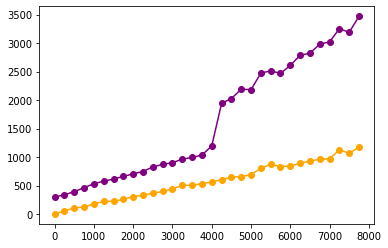

In [91]:
def time_number_positions(n):
    import magpylib as mag3
    ### Parameters
    max_distance = 5
    radius = 1 
    current = 1
    length = 1  # As ratio of radius how far from coil 
    off_axis_max = 0.25 # location in radial direction as percentage of radius
    tol = 1e-20 # tolerance of rustypy series convergence
    rustcoil = rpc.AxialSystem()
    rustcoil.transform_z()
    rustcoil.add_loop("loop",radius,0.0,current)
    unit_loop = mag3.current.Circular(current=1, diameter=2000,position=(0.0,0.0,0.0))  ##magpylib defines in mm
    get_magpy_fields = lambda positions: mag3.getB(sources=[unit_loop],observers=[positions]).sum(axis=0)

    number_grid_positions= int(np.sqrt(n))
    z_positions = np.linspace(-length,length,number_grid_positions)
    x_positions = np.linspace(0,off_axis_max*radius,number_grid_positions)
    g0,g1 = np.meshgrid(x_positions,z_positions)
    
    grid_positions = np.asarray(list(zip(g0.ravel(),np.zeros(number_grid_positions**2) ,g1.ravel())))
    grid_positions_magpy = np.asarray(list(zip(g0.ravel(),np.zeros(number_grid_positions**2) ,g1.ravel())))*1000
    
    time_rusty = timeit.timeit("rustcoil.get_b(grid_positions,1e-8)",globals=locals(),number=1000)/1000
    time_magpy = timeit.timeit("mag3.getB(sources=[unit_loop],observers=[grid_positions_magpy])",globals=locals(),number=1000)/1000
    
    return time_rusty*1e6,time_magpy*1e6

ns_many_pos = np.arange(1,8000,250)

times_rust_many_pos=[]
times_magpy_many_pos=[]
for n in ns_many_pos:
    t_r,t_m = time_number_positions(n)
    times_rust_many_pos.append(t_r)
    times_magpy_many_pos.append(t_m)
    
plt.scatter(ns_many_pos,times_rust_many_pos,c='orange')
plt.scatter(ns_many_pos,times_magpy_many_pos,c='purple')
plt.plot(ns_many_pos,times_rust_many_pos,c='orange')
plt.plot(ns_many_pos,times_magpy_many_pos,c='purple')




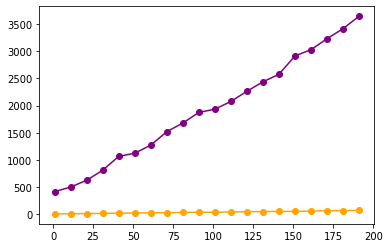

In [88]:
def time_number_positions_more_coils(n,coils):
    """
    """
    ### Parameters
    max_distance = 5
    radius = 1 
    current = 1
    length = 1  # As ratio of radius how far from coil 
    off_axis_max = 0.25 # location in radial direction as percentage of radius
    tol = 1e-20 # tolerance of rustypy series convergence
    rustcoil = rpc.AxialSystem()
    rustcoil.transform_z()
    mags=[]
    for c in range(0,coils):
        rustcoil.add_loop("loop"+str(c),radius,0.0,current)
        mags.append(mag3.current.Circular(current=1, diameter=2000,position=(0.0,0.0,0.0)))  ##magpylib defines in mm)
                    
    get_magpy_fields = lambda positions: mag3.getB(sources=mags,observers=[positions]).sum(axis=0)

    number_grid_positions= int(np.sqrt(n))
    z_positions = np.linspace(-length,length,number_grid_positions)
    x_positions = np.linspace(0,off_axis_max*radius,number_grid_positions)
    g0,g1 = np.meshgrid(x_positions,z_positions)
    
    grid_positions = np.asarray(list(zip(g0.ravel(),np.zeros(number_grid_positions**2) ,g1.ravel())))
    grid_positions_magpy = np.asarray(list(zip(g0.ravel(),np.zeros(number_grid_positions**2) ,g1.ravel())))*1000
    
    time_rusty = timeit.timeit("rustcoil.get_b(grid_positions,1e-8)",globals=locals(),number=100)/100
    time_magpy = timeit.timeit("get_magpy_fields(grid_positions_magpy).sum(axis=0)",globals=locals(),number=100)/100
    
    return time_rusty*1e6,time_magpy*1e6

number_coils = np.arange(1,200,10)
times_rust_many_coils=[]
times_magpy_many_coils=[]
for n in number_coils:
    t_r,t_m = time_number_positions_more_coils(1,n)
    times_rust_many_coils.append(t_r)
    times_magpy_many_coils.append(t_m)
    
    
plt.scatter(number_coils,times_rust_many_coils,c='orange')
plt.scatter(number_coils,times_magpy_many_coils,c='purple')
plt.plot(number_coils,times_rust_many_coils,c='orange')
plt.plot(number_coils,times_magpy_many_coils,c='purple')
    

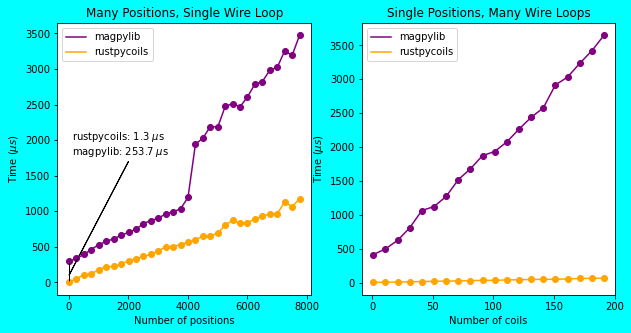

In [100]:

fig,(ax2,ax1) = plt.subplots(1,2,figsize=(10,5))


ax1.plot(number_coils,times_magpy_many_coils,c='purple',label='magpylib')
ax1.scatter(number_coils,times_magpy_many_coils,c='purple')

ax1.plot(number_coils,times_rust_many_coils,c='orange',label='rustpycoils')
ax1.scatter(number_coils,times_rust_many_coils,c='orange')

ax1.legend()
ax1.set_title('Single Positions, Many Wire Loops')



ax1.set_ylabel(r'Time ($\mu s$)')
ax1.set_xlabel('Number of coils')


ax2.plot(ns_many_pos,times_magpy_many_pos,c='purple',label='magpylib')
ax2.scatter(ns_many_pos,times_magpy_many_pos,c='purple')

ax2.plot(ns_many_pos,times_rust_many_pos,c='orange',label='rustpycoils')
ax2.scatter(ns_many_pos,times_rust_many_pos,c='orange')

ax2.set_xlabel('Number of positions')
ax2.set_ylabel(r'Time ($\mu s$)')
ax2.set_title('Many Positions, Single Wire Loop')

ax2.text(100,2000,"rustpycoils: " + str(round(time_rusty_single,1)) + r' $\mu$s')
ax2.text(100,1800,"magpylib: " + str(round(time_magpy_single,1))+ r' $\mu$s')
ax2.arrow(2000, 1700, -2000, -1600)
ax2.arrow(0, 0, 0, 270)

## draw a bbox of the region of the inset axes in the parent axes and
## connecting lines between the bbox and the inset axes area

ax2.legend()
ax1.set_ylabel(r'Time ($\mu s$)')

fig.patch.set_facecolor('cyan')
plt.savefig('speed_comparison.png')

SyntaxError: invalid syntax (<ipython-input-93-abefa8d9bb1a>, line 1)